# Importamos las librerias respectivas

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook, tnrange
%matplotlib inline

Using TensorFlow backend.


# Tipos de monstruos

## Se adquirio imagenes de 4 tipos de monstruos
  
### Beholders
<img src="imgs_/beholder.jpg" width="350px" align="left" style="float:left">
  <br style="clear:both">
  
### Goblins
<img src="imgs_/goblin.jpg" width="350px" align="left" style="float:left">
  <br style="clear:both">
  
### Mind flayers
<img src="imgs_/mind_flayer.jpg" width="350px" align="left" style="float:left">
  <br style="clear:both">
  
### Murlocs
<img src="imgs_/Murloc.png" width="350px" align="left" style="float:left">
  <br style="clear:both">

# Obtener imagenes

## Obtenemos las imagenes de cada monstruos

In [2]:
#!pip install requests

In [3]:
#from download import download

# Especificamos carpeta donde pusimos los archivos de texto y ejecutamos el metodo dobbbbwnload
path = 'monstruos'
#download(path)

# Cargar imagenes

In [4]:
#Dimensiones
img_size = 224
batch_size = 64

In [5]:
#Especificamos la función de preprocesamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 370 images belonging to 4 classes.


In [7]:
train_generator.class_indices

{'beholder': 0, 'goblin': 1, 'mindflayer': 2, 'murloc': 3}

murloc\murloc_pet_gm0.jpg


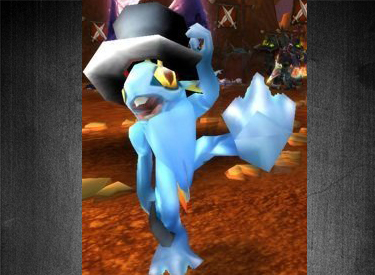

In [8]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + '/' + random_img)

# Definimos los modelos

## Red preentrenada

In [9]:
base_model = ResNet50(include_top=False, input_shape=(img_size,img_size,3), pooling='avg')
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_33 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_31[0][0]              
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________

## Cabecera de clasificacion


In [10]:
cls_model = Sequential()

cls_model.add(Dense(128, activation='relu', input_shape=(2048,)))
cls_model.add(Dense(train_generator.num_classes, activation='softmax'))

cls_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
cls_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 262,788
Trainable params: 262,788
Non-trainable params: 0
_________________________________________________________________


## Red completa

In [11]:
final_model = Sequential()

final_model.add(base_model)
final_model.add(cls_model)

final_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 4)                 262788    
Total params: 23,850,500
Trainable params: 262,788
Non-trainable params: 23,587,712
_________________________________________________________________


# Precompute

In [12]:
# Vamos a crear nuevamente el generator, pero esta vez con el parámetro "shuffle=False",
# para obtener los resultados en orden
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 370 images belonging to 4 classes.


In [13]:
n_batch = math.ceil(train_generator.samples / batch_size)
n_batch

6

In [14]:
# Reseteamos el status del generador para comenzar en orden
train_generator.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

# Usamos "tnrange" en lugar de "range" para tener más información del loop
for i in tnrange(n_batch):
    # Obtenemos la información del batch
    batch_x, batch_y = train_generator.next()

    # Guardamos el resultado del base_model
    outputs_x.append(base_model.predict_on_batch(batch_x))
    
    # Guardamos tambien los labels
    outputs_y.append(batch_y)
    
# Usamos la función "vstack" de numpy, para juntar los resultados en forma de un numpy array
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

C:\Users\labtel\Anaconda2\envs\ml\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


((370, 2048), (370, 4))

In [15]:
# Guardamos los arrays
np.savez_compressed('data/monster', x=outputs_x, y=outputs_y)

In [16]:
# Cargar arrays
data = np.load('data/monster.npz')
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((370, 2048), (370, 4))

# Entrenar a partir de los features extraidos

In [17]:
log = cls_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
370/370 [==============================] - ETA: 0s - loss: 1.5941 - acc: 0.246 - 1s 2ms/step - loss: 1.6170 - acc: 0.3162
Epoch 2/5
370/370 [==============================] - ETA: 0s - loss: 1.0141 - acc: 0.640 - 0s 83us/step - loss: 0.8772 - acc: 0.6811
Epoch 3/5
370/370 [==============================] - ETA: 0s - loss: 0.5174 - acc: 0.828 - 0s 78us/step - loss: 0.4984 - acc: 0.8378
Epoch 4/5
370/370 [==============================] - ETA: 0s - loss: 0.3041 - acc: 0.918 - 0s 70us/step - loss: 0.2866 - acc: 0.9162
Epoch 5/5
370/370 [==============================] - ETA: 0s - loss: 0.2125 - acc: 0.929 - 0s 73us/step - loss: 0.2030 - acc: 0.9378


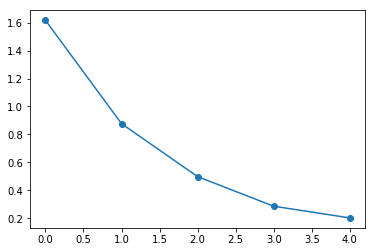

In [18]:
plt.plot(log.history['loss'], '-o');

# Probando el modelo

In [19]:
lbl_dict = {k:i for i,k in train_generator.class_indices.items()}

def get_class(path):
    # Cargar la imagen del path
    img = Image.open(path).convert('RGB')
    
    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    
    # Cambiar el tamaño de la imagen
    img_resized = img.resize((224, 224))
    
    # Cambiar a formato numpy y preprocesar
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)
    
    # Obtener predicciones
    y = final_model.predict(x)
    
    # Decodear predicciones
    pred = lbl_dict[np.argmax(y)]
    
    plt.title(f'Model prediction = {pred}')
    plt.show()

monstruos/goblin\goblins-dd-nolzurs-marvelous.jpg


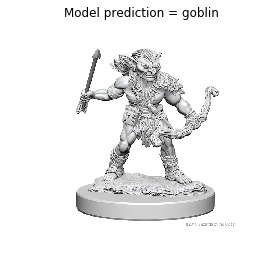

monstruos/goblin\Goblin-Commando-DD-miniature-Pathfinder-miniature-DnD-mini.jpg


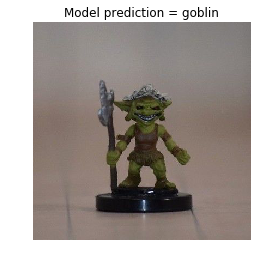

monstruos/murloc\2177019_1.jpg


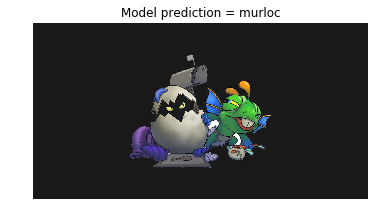

monstruos/murloc\R33VLBVL3WL51400264804627.jpg


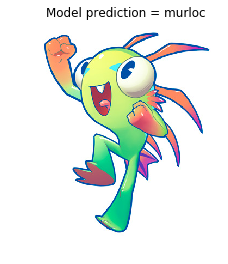

monstruos/goblin\2018-01-07-1.png


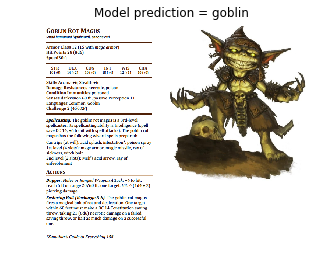

In [33]:
# Nro de pruebas
n = 5

for _ in range(n):
    # Escoger una imagene al azar
    random_path = path + '/' + np.random.choice(train_generator.filenames)
    print(random_path)

    # Obtener la clasificación de la imagen
    get_class(random_path)